<a href="https://colab.research.google.com/github/divyanshbajpai/EVA4-Coursework/blob/master/Assignment-6/S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Target: Change Learning Rate
- Result: The val accuracy increased. 99.4%+ acc is more often.
  - Parameters: 9,752
  - Best Train Accuracy: 99.20%
  - Best Test Accuracy: 99.44%
- Analysis:
 - The model is performing well, as more and more 99.4% above val acc is seen
 - Many hits and trial were required, as little change to LR changed the accuracies drastically.
 - Still not sure wheather this LR is the best? Many more permuatation and combinations are required.



# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26, RF= 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
train_acc = []
test_losses = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,reg):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    
    loss = F.nll_loss(y_pred, target)
      
    if reg is 1:
      l1_crit = nn.L1Loss(size_average=False)
      reg_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param) * 0
        reg_loss += l1_crit(param, zero_vector)        
      loss += 0.0005 * reg_loss 
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
# from torch.optim.lr_scheduler import StepLR

# model =  Net().to(device)
# optimizer1 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# optimizer2 = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# # scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


# EPOCHS = 41
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     if epoch <= 10:
#       optimizer = optimizer1
#     else:
#       optimizer = optimizer2
#     train(model, device, train_loader, optimizer, epoch)
#     # scheduler.step()
#     test(model, device, test_loader)

In [9]:
print(train_acc)

[]


Text(0.5, 1.0, 'Test Accuracy')

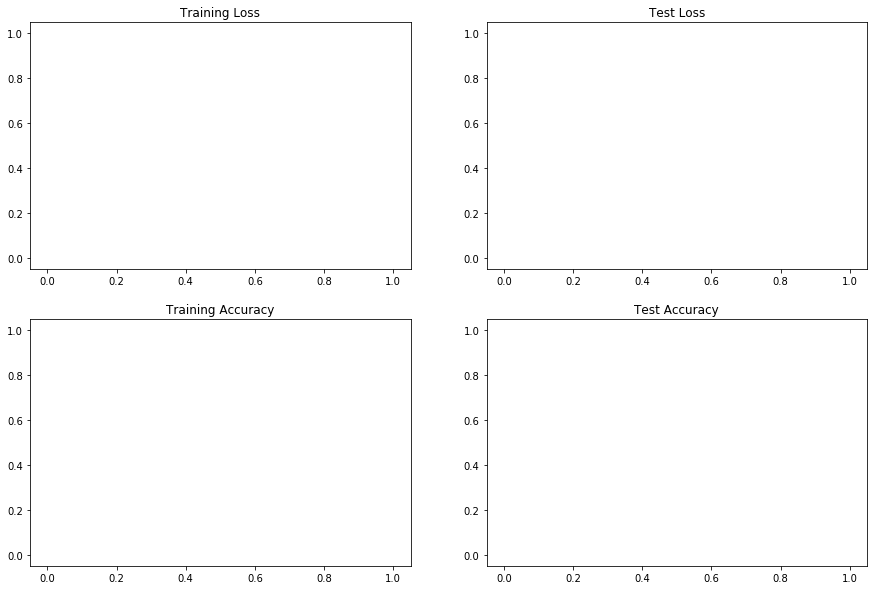

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
# torch.save({ 'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'train_loss':train_losses,'test_loss':test_losses,'val_acc':test_acc }, 'generic.pt')

In [0]:
m1 =  Net().to(device)
m2 =  Net().to(device)
m3 =  Net().to(device)
m4 =  Net().to(device)


In [0]:
tr_l=[]
tr_a=[]
ts_l=[]
ts_a=[]
def multiplemodel(model,reg):
  global tr_l
  global tr_a
  global ts_l
  global ts_a
  regul=0
  if reg=='':
    optimizer1 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    optimizer2 = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
  if reg=='l2':
    optimizer2 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9,weight_decay=0.005)
  if reg=='l1':
    optimizer2 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    regul=1
  if reg=='l12':
    optimizer2 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9,weight_decay=0.005)
    regul=1
  EPOCHS = 40

  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    if epoch <= 10 and reg=='':
      optimizer = optimizer1
    else:
      optimizer = optimizer2
    train(model, device, train_loader, optimizer, epoch,regul)
    # scheduler.step()
    test(model, device, test_loader)
  tr_l.append(train_losses.copy())
  tr_a.append(train_acc.copy())
  ts_l.append(test_losses.copy())
  ts_a.append(test_acc.copy())
  train_losses.clear()
  train_acc.clear()
  test_acc.clear()
  test_losses.clear()

In [14]:
multiplemodel(m1,'')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.05247585102915764 Batch_id=468 Accuracy=90.76: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0779, Accuracy: 9765/10000 (97.65%)

EPOCH: 1


Loss=0.021942690014839172 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.17190510034561157 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.04681814834475517 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.08806029707193375 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.024018576368689537 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.14827321469783783 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.07000529766082764 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 37.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.07906873524188995 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.07844942808151245 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.0050157904624938965 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.060443367809057236 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.01357857882976532 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.031109020113945007 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.01039867103099823 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.03159448876976967 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.027470866218209267 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.0034534037113189697 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.07775213569402695 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.00787651538848877 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH: 20


Loss=0.010106772184371948 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.009059508331120014 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 38.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)

EPOCH: 22


Loss=0.039489757269620895 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.017034629359841347 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.05831701681017876 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.022948911413550377 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9942/10000 (99.42%)

EPOCH: 26


Loss=0.067476786673069 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 27


Loss=0.010565991513431072 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 38.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9941/10000 (99.41%)

EPOCH: 28


Loss=0.0025295913219451904 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 38.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9939/10000 (99.39%)

EPOCH: 29


Loss=0.024108529090881348 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 30


Loss=0.033159684389829636 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.003789598820731044 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 39.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9940/10000 (99.40%)

EPOCH: 32


Loss=0.001904646516777575 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)

EPOCH: 33


Loss=0.08039532601833344 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9943/10000 (99.43%)

EPOCH: 34


Loss=0.009575098752975464 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


Loss=0.00560373580083251 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.013227607123553753 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 36.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9938/10000 (99.38%)

EPOCH: 37


Loss=0.008143395185470581 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


Loss=0.004554370883852243 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9952/10000 (99.52%)

EPOCH: 39


Loss=0.022667795419692993 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]



Test set: Average loss: 0.0157, Accuracy: 9945/10000 (99.45%)



In [15]:
multiplemodel(m2,'l1')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.30421286821365356 Batch_id=468 Accuracy=90.19: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1160, Accuracy: 9647/10000 (96.47%)

EPOCH: 1


Loss=0.35268113017082214 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:16<00:00, 28.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9738/10000 (97.38%)

EPOCH: 2


Loss=0.23051296174526215 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:16<00:00, 29.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0699, Accuracy: 9772/10000 (97.72%)

EPOCH: 3


Loss=0.3384355306625366 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.2458811104297638 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9823/10000 (98.23%)

EPOCH: 5


Loss=0.2825431525707245 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9851/10000 (98.51%)

EPOCH: 6


Loss=0.3518736958503723 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9822/10000 (98.22%)

EPOCH: 7


Loss=0.18917043507099152 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9864/10000 (98.64%)

EPOCH: 8


Loss=0.24202291667461395 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:16<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9866/10000 (98.66%)

EPOCH: 9


Loss=0.21203184127807617 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9880/10000 (98.80%)

EPOCH: 10


Loss=0.21304063498973846 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:16<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9875/10000 (98.75%)

EPOCH: 11


Loss=0.22494986653327942 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9889/10000 (98.89%)

EPOCH: 12


Loss=0.22284743189811707 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9861/10000 (98.61%)

EPOCH: 13


Loss=0.1957235038280487 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9851/10000 (98.51%)

EPOCH: 14


Loss=0.21707062423229218 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9844/10000 (98.44%)

EPOCH: 15


Loss=0.23063990473747253 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9852/10000 (98.52%)

EPOCH: 16


Loss=0.1884642243385315 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9866/10000 (98.66%)

EPOCH: 17


Loss=0.28043249249458313 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:16<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9840/10000 (98.40%)

EPOCH: 18


Loss=0.23263123631477356 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9859/10000 (98.59%)

EPOCH: 19


Loss=0.20620378851890564 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9865/10000 (98.65%)

EPOCH: 20


Loss=0.21776890754699707 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 34.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9802/10000 (98.02%)

EPOCH: 21


Loss=0.1886034607887268 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9819/10000 (98.19%)

EPOCH: 22


Loss=0.18016383051872253 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9890/10000 (98.90%)

EPOCH: 23


Loss=0.25376033782958984 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9866/10000 (98.66%)

EPOCH: 24


Loss=0.21538439393043518 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9866/10000 (98.66%)

EPOCH: 25


Loss=0.2953755259513855 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9835/10000 (98.35%)

EPOCH: 26


Loss=0.25135135650634766 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9812/10000 (98.12%)

EPOCH: 27


Loss=0.23404991626739502 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9821/10000 (98.21%)

EPOCH: 28


Loss=0.19253429770469666 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9892/10000 (98.92%)

EPOCH: 29


Loss=0.37155383825302124 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9842/10000 (98.42%)

EPOCH: 30


Loss=0.2607046663761139 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9876/10000 (98.76%)

EPOCH: 31


Loss=0.26923489570617676 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9862/10000 (98.62%)

EPOCH: 32


Loss=0.1686849445104599 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9849/10000 (98.49%)

EPOCH: 33


Loss=0.24246501922607422 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9872/10000 (98.72%)

EPOCH: 34


Loss=0.3343196213245392 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9872/10000 (98.72%)

EPOCH: 35


Loss=0.3227250874042511 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9843/10000 (98.43%)

EPOCH: 36


Loss=0.18427100777626038 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9816/10000 (98.16%)

EPOCH: 37


Loss=0.23278847336769104 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 36.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9818/10000 (98.18%)

EPOCH: 38


Loss=0.2570468783378601 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9855/10000 (98.55%)

EPOCH: 39


Loss=0.20514121651649475 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]



Test set: Average loss: 0.0484, Accuracy: 9844/10000 (98.44%)



In [16]:
multiplemodel(m3,'l2')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10980776697397232 Batch_id=468 Accuracy=90.25: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Accuracy: 9785/10000 (97.85%)

EPOCH: 1


Loss=0.07355304807424545 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.11464359611272812 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1101, Accuracy: 9710/10000 (97.10%)

EPOCH: 3


Loss=0.07262035459280014 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9840/10000 (98.40%)

EPOCH: 4


Loss=0.12430807203054428 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9849/10000 (98.49%)

EPOCH: 5


Loss=0.056996989995241165 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1048, Accuracy: 9716/10000 (97.16%)

EPOCH: 6


Loss=0.0463726781308651 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0686, Accuracy: 9838/10000 (98.38%)

EPOCH: 7


Loss=0.0946415439248085 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1013, Accuracy: 9746/10000 (97.46%)

EPOCH: 8


Loss=0.12049600481987 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9868/10000 (98.68%)

EPOCH: 9


Loss=0.07645323127508163 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0931, Accuracy: 9750/10000 (97.50%)

EPOCH: 10


Loss=0.06824462115764618 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Accuracy: 9815/10000 (98.15%)

EPOCH: 11


Loss=0.07582917809486389 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9829/10000 (98.29%)

EPOCH: 12


Loss=0.06174697354435921 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1025, Accuracy: 9736/10000 (97.36%)

EPOCH: 13


Loss=0.2122311145067215 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9850/10000 (98.50%)

EPOCH: 14


Loss=0.08049868792295456 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0923, Accuracy: 9738/10000 (97.38%)

EPOCH: 15


Loss=0.05567579343914986 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9837/10000 (98.37%)

EPOCH: 16


Loss=0.1103585958480835 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9889/10000 (98.89%)

EPOCH: 17


Loss=0.08737611025571823 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 32.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9856/10000 (98.56%)

EPOCH: 18


Loss=0.07182971388101578 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 33.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9881/10000 (98.81%)

EPOCH: 19


Loss=0.10581179708242416 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Accuracy: 9757/10000 (97.57%)

EPOCH: 20


Loss=0.08478472381830215 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:19<00:00, 23.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9809/10000 (98.09%)

EPOCH: 21


Loss=0.11757992953062057 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0986, Accuracy: 9738/10000 (97.38%)

EPOCH: 22


Loss=0.08607828617095947 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 36.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9869/10000 (98.69%)

EPOCH: 23


Loss=0.19869761168956757 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9840/10000 (98.40%)

EPOCH: 24


Loss=0.05404403805732727 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9858/10000 (98.58%)

EPOCH: 25


Loss=0.09410399198532104 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:15<00:00, 35.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9711/10000 (97.11%)

EPOCH: 26


Loss=0.1541324108839035 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9816/10000 (98.16%)

EPOCH: 27


Loss=0.10279802232980728 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9893/10000 (98.93%)

EPOCH: 28


Loss=0.06425004452466965 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0799, Accuracy: 9799/10000 (97.99%)

EPOCH: 29


Loss=0.14728717505931854 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 9838/10000 (98.38%)

EPOCH: 30


Loss=0.15752869844436646 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9840/10000 (98.40%)

EPOCH: 31


Loss=0.06610247492790222 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9848/10000 (98.48%)

EPOCH: 32


Loss=0.1826595664024353 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0810, Accuracy: 9805/10000 (98.05%)

EPOCH: 33


Loss=0.06955792009830475 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9890/10000 (98.90%)

EPOCH: 34


Loss=0.0871250107884407 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9870/10000 (98.70%)

EPOCH: 35


Loss=0.061195891350507736 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 30.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9825/10000 (98.25%)

EPOCH: 36


Loss=0.1316428929567337 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9832/10000 (98.32%)

EPOCH: 37


Loss=0.1522192806005478 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0677, Accuracy: 9824/10000 (98.24%)

EPOCH: 38


Loss=0.07934361696243286 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0842, Accuracy: 9809/10000 (98.09%)

EPOCH: 39


Loss=0.07907548546791077 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]



Test set: Average loss: 0.0571, Accuracy: 9855/10000 (98.55%)



In [17]:
multiplemodel(m4,'l12')

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.31138932704925537 Batch_id=468 Accuracy=90.06: 100%|██████████| 469/469 [00:17<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1676, Accuracy: 9531/10000 (95.31%)

EPOCH: 1


Loss=0.3524898290634155 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:16<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1152, Accuracy: 9696/10000 (96.96%)

EPOCH: 2


Loss=0.30795997381210327 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0926, Accuracy: 9749/10000 (97.49%)

EPOCH: 3


Loss=0.24373050034046173 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1195, Accuracy: 9697/10000 (96.97%)

EPOCH: 4


Loss=0.27570685744285583 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0765, Accuracy: 9806/10000 (98.06%)

EPOCH: 5


Loss=0.22505062818527222 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1032, Accuracy: 9720/10000 (97.20%)

EPOCH: 6


Loss=0.27000999450683594 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1008, Accuracy: 9742/10000 (97.42%)

EPOCH: 7


Loss=0.33913537859916687 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1197, Accuracy: 9653/10000 (96.53%)

EPOCH: 8


Loss=0.28800588846206665 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1073, Accuracy: 9728/10000 (97.28%)

EPOCH: 9


Loss=0.20872166752815247 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1170, Accuracy: 9665/10000 (96.65%)

EPOCH: 10


Loss=0.24997207522392273 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1247, Accuracy: 9684/10000 (96.84%)

EPOCH: 11


Loss=0.208979070186615 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0941, Accuracy: 9785/10000 (97.85%)

EPOCH: 12


Loss=0.21339726448059082 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:17<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1459, Accuracy: 9633/10000 (96.33%)

EPOCH: 13


Loss=0.24147886037826538 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9793/10000 (97.93%)

EPOCH: 14


Loss=0.2326957881450653 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1307, Accuracy: 9653/10000 (96.53%)

EPOCH: 15


Loss=0.22270917892456055 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1568, Accuracy: 9592/10000 (95.92%)

EPOCH: 16


Loss=0.23048165440559387 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 9783/10000 (97.83%)

EPOCH: 17


Loss=0.2467755377292633 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1266, Accuracy: 9649/10000 (96.49%)

EPOCH: 18


Loss=0.20872721076011658 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0856, Accuracy: 9797/10000 (97.97%)

EPOCH: 19


Loss=0.21128493547439575 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9847/10000 (98.47%)

EPOCH: 20


Loss=0.26836469769477844 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1150, Accuracy: 9681/10000 (96.81%)

EPOCH: 21


Loss=0.20964756608009338 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:17<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1163, Accuracy: 9684/10000 (96.84%)

EPOCH: 22


Loss=0.24254445731639862 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1341, Accuracy: 9625/10000 (96.25%)

EPOCH: 23


Loss=0.34803593158721924 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 9852/10000 (98.52%)

EPOCH: 24


Loss=0.2090502381324768 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Accuracy: 9795/10000 (97.95%)

EPOCH: 25


Loss=0.223054438829422 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1176, Accuracy: 9681/10000 (96.81%)

EPOCH: 26


Loss=0.19191110134124756 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1276, Accuracy: 9664/10000 (96.64%)

EPOCH: 27


Loss=0.24813729524612427 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:17<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9803/10000 (98.03%)

EPOCH: 28


Loss=0.2240716516971588 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1937, Accuracy: 9405/10000 (94.05%)

EPOCH: 29


Loss=0.3046302795410156 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0954, Accuracy: 9767/10000 (97.67%)

EPOCH: 30


Loss=0.1797148734331131 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9859/10000 (98.59%)

EPOCH: 31


Loss=0.1824977695941925 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0741, Accuracy: 9852/10000 (98.52%)

EPOCH: 32


Loss=0.2775704264640808 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0830, Accuracy: 9771/10000 (97.71%)

EPOCH: 33


Loss=0.19236351549625397 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0792, Accuracy: 9796/10000 (97.96%)

EPOCH: 34


Loss=0.276968389749527 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1036, Accuracy: 9737/10000 (97.37%)

EPOCH: 35


Loss=0.2420022338628769 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1587, Accuracy: 9575/10000 (95.75%)

EPOCH: 36


Loss=0.2188834547996521 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9775/10000 (97.75%)

EPOCH: 37


Loss=0.19310159981250763 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1000, Accuracy: 9755/10000 (97.55%)

EPOCH: 38


Loss=0.17464008927345276 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:17<00:00, 27.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0789, Accuracy: 9809/10000 (98.09%)

EPOCH: 39


Loss=0.19827425479888916 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:17<00:00, 27.19it/s]



Test set: Average loss: 0.0919, Accuracy: 9770/10000 (97.70%)



In [0]:
def plot_history(lists, labels, title=None, xlabel='epochs', ylabel=None):
    '''
    Take list of sequences and their respective label and plot them
    '''
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    for vals, label in zip(lists, labels):
        plt.plot(vals, label=label)
    plt.legend()
    plt.show()


labels = ['No L1 or L2', 'Only L1', 'Only L2', 'Both L1 and L2']

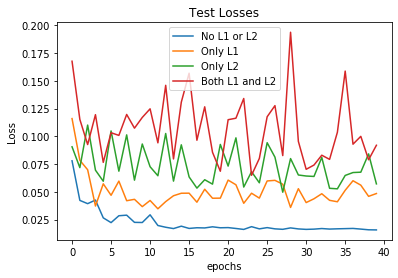

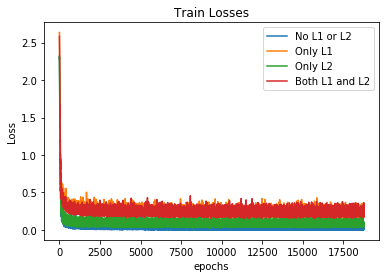

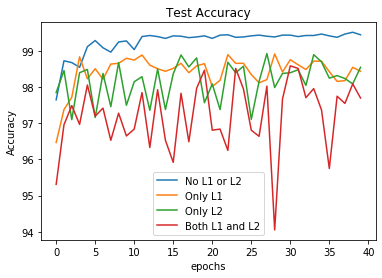

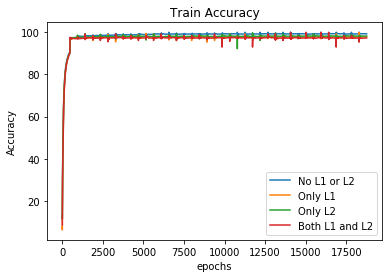

In [19]:
plot_history(ts_l, labels, title='Test Losses', ylabel='Loss')
plot_history(tr_l, labels, title='Train Losses', ylabel='Loss')
plot_history(ts_a, labels, title='Test Accuracy', ylabel='Accuracy')
plot_history(tr_a, labels, title='Train Accuracy', ylabel='Accuracy')